# Face Recognition - Data Preparation and PCA
This notebook covers loading the ORL face dataset, preparing the data matrix and label vector, and performing PCA using scikit-learn.

In [1]:
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Constants
IMAGE_WIDTH = 92
IMAGE_HEIGHT = 112
DATASET_PATH = './data/'  # Change this to your actual dataset path

def load_images_and_labels(dataset_path):
    data = []
    labels = []
    for subject_id in range(1, 41):
        subject_path = os.path.join(dataset_path, f's{subject_id}')
        for img_name in os.listdir(subject_path):
            img_path = os.path.join(subject_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_flat = img.flatten()
            data.append(img_flat)
            labels.append(subject_id)
    return np.array(data), np.array(labels)

# Load images and labels
X, y = load_images_and_labels(DATASET_PATH)
print(f'Data shape: {X.shape}, Labels shape: {y.shape}')

Data shape: (400, 10304), Labels shape: (400,)


In [2]:
# Split into training and testing
X_train = X[::2]
y_train = y[::2]
X_test = X[1::2]
y_test = y[1::2]

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (200, 10304), Test shape: (200, 10304)


Alpha: 0.8, Components retained: 36


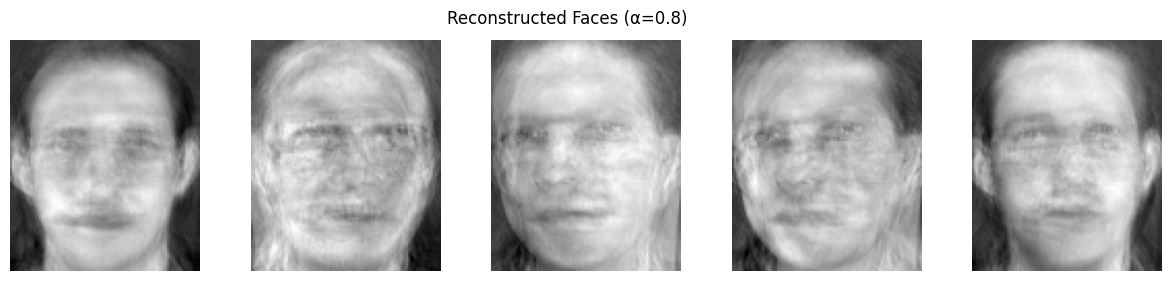

Alpha: 0.85, Components retained: 52


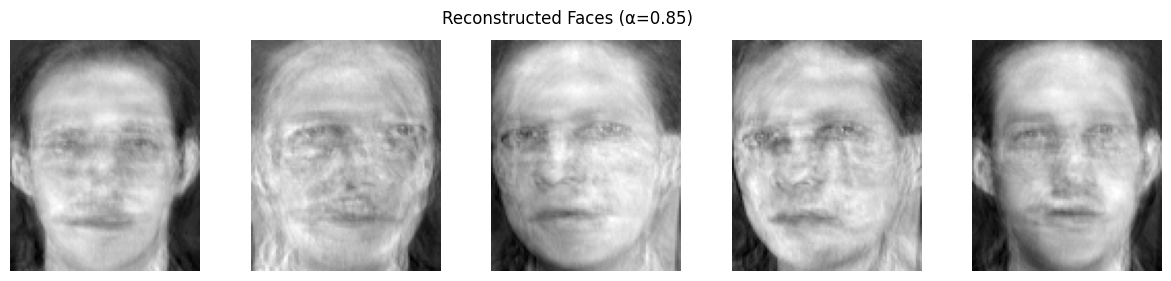

Alpha: 0.9, Components retained: 76


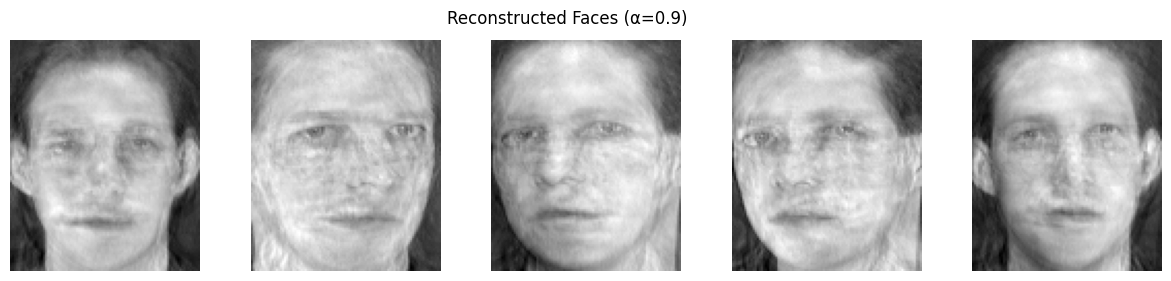

Alpha: 0.95, Components retained: 115


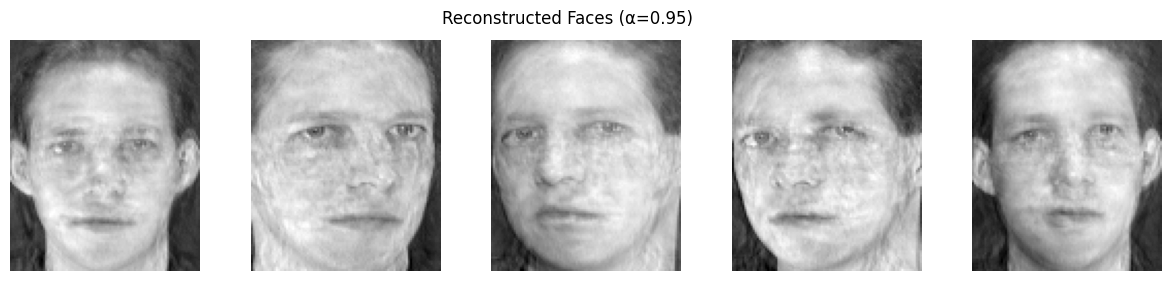

In [3]:
# PCA with variance retention
alphas = [0.8, 0.85, 0.9, 0.95]
pca_results = {}

for alpha in alphas:
    pca = PCA(n_components=alpha, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    print(f'Alpha: {alpha}, Components retained: {pca.n_components_}')
    pca_results[alpha] = {
        'pca': pca,
        'X_train_pca': X_train_pca,
        'X_test_pca': X_test_pca,
    }

    # Visualize a few reconstructed faces
    reconstructed = pca.inverse_transform(X_train_pca[:5])
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        axs[i].imshow(reconstructed[i].reshape((112, 92)), cmap='gray')
        axs[i].axis('off')
    plt.suptitle(f'Reconstructed Faces (α={alpha})')
    plt.show()

In [4]:
# Save arrays for reuse in clustering step
np.save('./npy/X_train.npy', X_train)
np.save('./npy/X_test.npy', X_test)
np.save('./npy/y_train.npy', y_train)
np.save('./npy/y_test.npy', y_test)
for alpha in alphas:
    np.save(f'./npy/pca_alpha_{alpha}_train.npy', pca_results[alpha]['X_train_pca'])
    np.save(f'./npy/pca_alpha_{alpha}_test.npy', pca_results[alpha]['X_test_pca'])

## KMeans Algorithm

In [11]:
import importlib
import kmeans as Models
import matplotlib.pyplot as plt

importlib.reload(Models)

<module 'kmeans' from 'm:\\FOE AU\\CSE 3\\second-term\\Pattern Recognition\\assignments\\Face_Recognition_Problem\\kmeans.py'>

In [18]:
k_values = [20, 40, 60]
results = {}  # To store accuracy for each (alpha, K)

best_acc = 0
best_model = Models.KMeans()
best_alpha = 0.8
for alpha in alphas:
    results[alpha] = {}
    for k in k_values:
        kmeans_model = Models.KMeans()
        pca = pca_results[alpha]['pca']
        X_train_pca = pca_results[alpha]['X_train_pca']
        X_test_pca = pca_results[alpha]['X_test_pca']

        # Fit KMeans
        kmeans_model.fit(X_train_pca, n_clusters=k, true_labels=y_train)

        # Predict clusters
        y_pred_train = kmeans_model.predict(X_train_pca)

        acc = kmeans_model.get_accuracy(y_pred_train, y_train)

        if acc > best_acc:
            best_acc = acc
            best_model = kmeans_model
            best_alpha = alpha

        results[alpha][k] = acc  # Save the accuracy

        print(f'Alpha: {alpha}, K: {k}, Training Accuracy: {acc:.4f}')




Alpha: 0.8, K: 20, Training Accuracy: 0.4100
Alpha: 0.8, K: 40, Training Accuracy: 0.7200
Alpha: 0.8, K: 60, Training Accuracy: 0.7200
Alpha: 0.85, K: 20, Training Accuracy: 0.4150
Alpha: 0.85, K: 40, Training Accuracy: 0.6600
Alpha: 0.85, K: 60, Training Accuracy: 0.8100
Alpha: 0.9, K: 20, Training Accuracy: 0.4300
Alpha: 0.9, K: 40, Training Accuracy: 0.6450
Alpha: 0.9, K: 60, Training Accuracy: 0.7100
Alpha: 0.95, K: 20, Training Accuracy: 0.4400
Alpha: 0.95, K: 40, Training Accuracy: 0.6900
Alpha: 0.95, K: 60, Training Accuracy: 0.7450


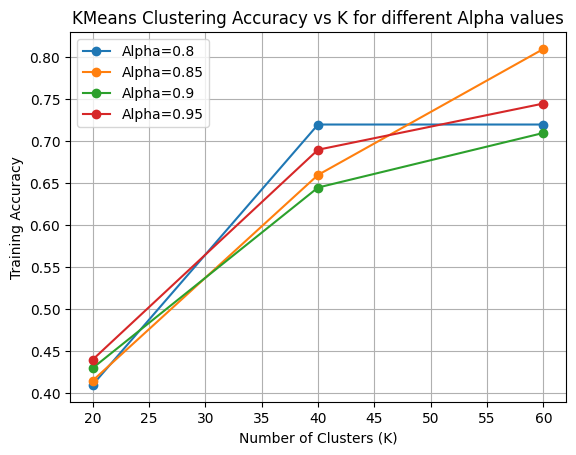

In [19]:
for alpha in results:
    plt.plot(k_values, [results[alpha][k] for k in k_values], marker='o', label=f'Alpha={alpha}')

plt.xlabel('Number of Clusters (K)')
plt.ylabel('Training Accuracy')
plt.title('KMeans Clustering Accuracy vs K for different Alpha values')
plt.legend()
plt.grid(True)
plt.show()

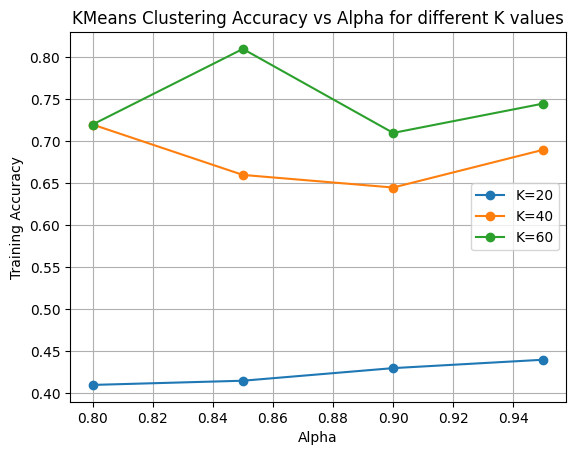

In [20]:
for k in k_values:
    accuracies = [results[alpha][k] for alpha in alphas]
    plt.plot(alphas, accuracies, marker='o', label=f'K={k}')

plt.xlabel('Alpha')
plt.ylabel('Training Accuracy')
plt.title('KMeans Clustering Accuracy vs Alpha for different K values')
plt.legend()
plt.grid(True)
plt.show()

**Best K-Means Model Evaluating**

- k = 60
- alpha = 0.8

In [23]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

Test Accuracy: 0.7300
Test F1-Score: 0.6897


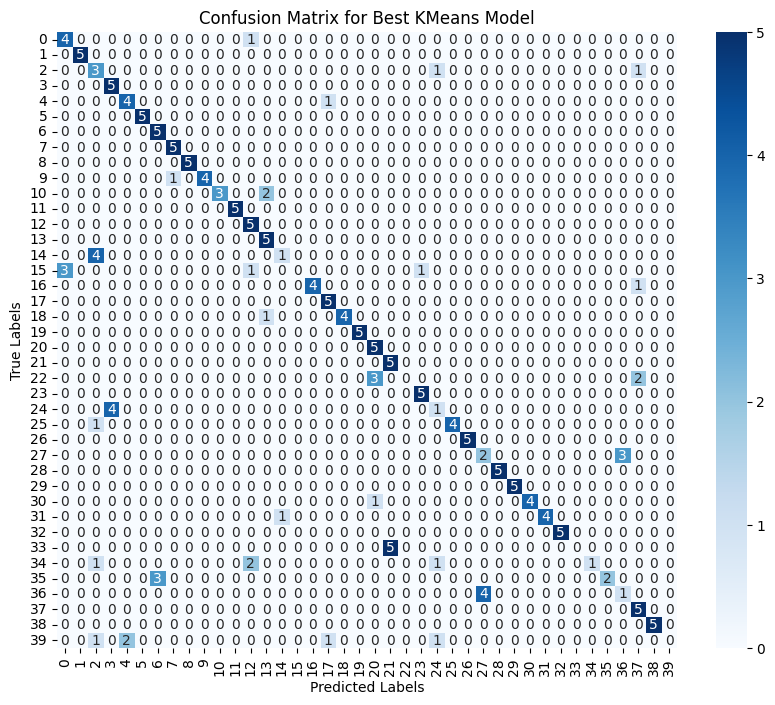

In [24]:
pca = pca_results[best_alpha]['pca']
X_test_pca = pca_results[best_alpha]['X_test_pca']

# Predict clusters for the test set
y_pred_test = best_model.predict(X_test_pca)

# Calculate Accuracy
test_accuracy = best_model.get_accuracy(y_pred_test, y_test)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_test, average='macro')  # or 'weighted'

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print Results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Best KMeans Model')
plt.show()